In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.linear_model import LinearRegression
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import sys
sys.setrecursionlimit(10000)

# Part 1: Clustering 

In [2]:
fpkm=pd.read_csv("all_annotated.csv")

In [3]:
#discards columns with a median of zero
fpkm['Keep']=np.where(fpkm.median(axis=1,numeric_only=True)>0,True,False)
fpkm=fpkm[fpkm['Keep']==True]
fpkm

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D,Keep
3,FBtr0302347,CR40182,23.712564,11.967821,20.767498,13.566818,18.802116,26.802691,22.819895,11.682728,21.894249,13.922059,16.482141,12.622680,31.800016,22.883186,14.330216,17.202570,True
8,FBtr0113885,Parp,10.997173,0.000000,0.000000,0.000000,14.805335,0.000000,17.601667,10.729349,0.000000,0.000000,14.888651,14.518989,20.343670,4.087385,0.000000,25.284622,True
9,FBtr0301810,Alg-2,19.067924,0.000000,14.832370,27.793905,22.290230,7.846396,13.839143,12.905621,18.570707,2.919183,18.402807,26.431841,27.464781,7.432775,7.349162,22.792486,True
10,FBtr0113895,Tim17b,6.315716,3.935390,6.244336,69.942917,67.208557,7.605970,74.979057,53.740307,44.747662,16.834093,52.928318,77.950165,80.805580,31.863932,49.121342,77.608521,True
11,FBtr0345179,Tim17b,119.325905,11.631035,120.137291,75.778061,72.815582,123.849213,81.234352,59.657963,48.480839,18.238514,57.343983,86.686310,87.546967,34.522255,53.219402,84.936600,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,33.341347,1.056151,9.832860,414.872559,102.529091,25.448748,71.750275,123.175087,119.770973,0.672975,48.309597,71.916695,237.404190,43.700970,75.445251,167.244049,True
34665,FBtr0100886,mt:ND1,25.209366,0.638430,21.281239,517.077271,326.313934,54.783924,360.265900,222.375244,306.410706,2.153615,200.718567,392.145020,433.656708,21.621773,91.902115,681.475891,True
34667,FBtr0100888,mt:lrRNA,2339.313232,34.080185,927.591858,4944.716797,2251.114990,593.744141,2493.088379,1651.994141,2578.825439,76.555481,2175.402344,3736.670654,122.910004,451.278412,692.211304,4556.642090,True
34684,FBtr0114261,CR41590,0.072563,0.000000,0.096390,0.102807,0.000000,0.000000,0.000000,0.126345,0.902268,0.000000,0.000000,0.162814,0.165381,0.000000,0.000000,0.052507,True


In [4]:
#fpkm transformation 
log_fpkm=fpkm.apply(lambda x:np.log2(x+0.1) if np.issubdtype(x.dtype, np.number) else x)
log_fpkm.pop("Keep")
log_fpkm

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,FBtr0302347,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,FBtr0113885,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,FBtr0301810,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,FBtr0113895,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,FBtr0345179,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,FBtr0100886,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,FBtr0100888,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,FBtr0114261,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [5]:
#clustering 
clust_data=log_fpkm.values
#removes name columns 
clust_data_2=np.delete(clust_data,(0,1),1)
clust_data_trans=np.transpose(clust_data_2)
#linkage for samples and genes
z=linkage(clust_data_2)
z_trans=linkage(clust_data_trans)

In [6]:
#labels for the heatmap
gene_labels=leaves_list(z)
gene_names=[]
sample_labels=leaves_list(z_trans)
#gets the gene names in the right order
col_names=[]
for i in gene_labels: 
    gene_names.append(clust_data[i][1])
#gets the gene names in the right order

cols=log_fpkm.columns.tolist()[2:]
for j in sample_labels:
    col_names.append(cols[j])


[ 6 14  7 15  5 13  1  4 12 11  9  3  8  0  2 10]
['male_14C', 'female_14C', 'male_14D', 'female_14D', 'male_14B', 'female_14B', 'male_11', 'male_14A', 'female_14A', 'female_13', 'female_11', 'male_13', 'female_10', 'male_10', 'male_12', 'female_12']


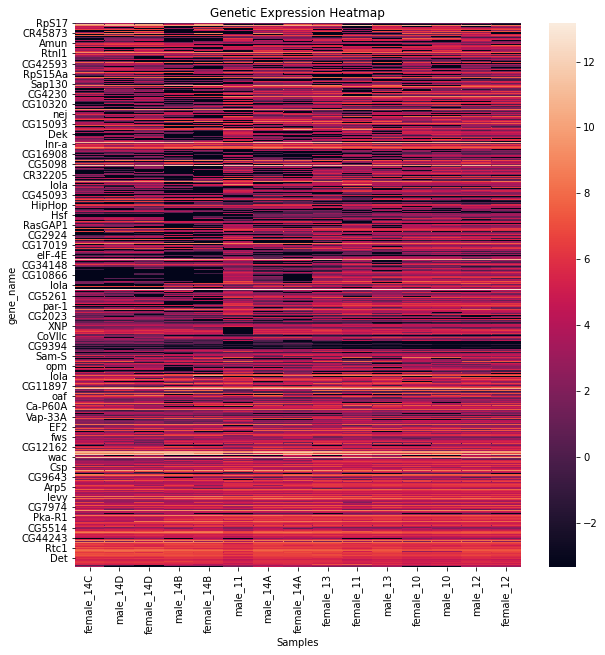

In [166]:
#reoreders columns and rows
#comment out below line after first run
log_fpkm=log_fpkm.set_index("gene_name")
#maps heatmap 
fig,ax=plt.subplots(figsize=(10,10))
log_fpkm2=log_fpkm2[col_names]
ax=sns.heatmap(log_fpkm2.iloc[:, 1:])
ax.set_title("Genetic Expression Heatmap")
ax.set_xlabel("Samples")
plt.show()

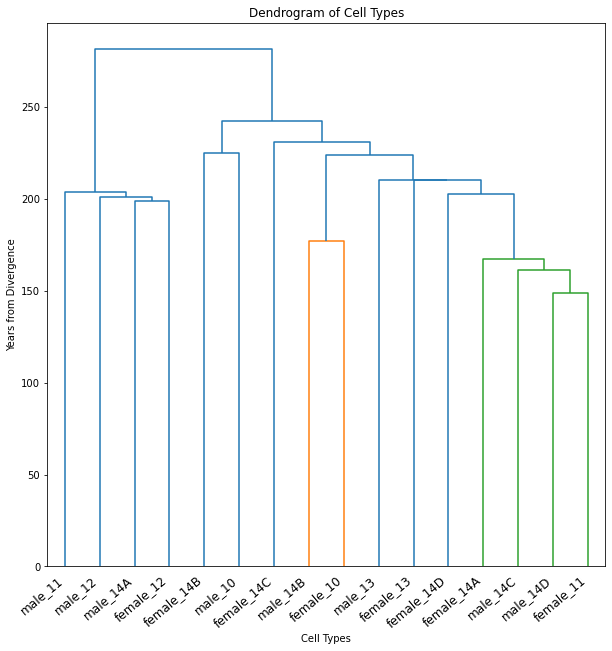

In [13]:
#Dendrogram of cell types 
fig,ax=plt.subplots(figsize=(10,10))
dendrogram(z_trans,p=16, truncate_mode='level',labels=col_names)
plt.xticks(rotation=40, ha='right')
ax.set_title("Dendrogram of Cell Types")
ax.set_xlabel("Cell Types")
ax.set_ylabel("Generations from Divergence")
plt.show()

# Part 2 Differential Expression

In [146]:
#make a data point for each day 
gene_names=[]
p_values=[]
for index,row in log_fpkm.iterrows():
    x=[10,10,11,11,12,12,13,13,14,14,14,14,14,14,14,14]
    y=[row['male_10'],row['female_10'],row['male_11'],row['female_11'],row['male_12'],
       row['female_12'],row['male_13'],row['female_13'],row['male_14A'],row['male_14B'],row['male_14C'],
       row['male_14D'],row['female_14A'],row['female_14B'],row['female_14C'],row['male_14D']]
    #linear model, adding a constant to independent variable 
    y2=sm.add_constant(y)
    model=sm.OLS(x,y2)
    model_test=model.fit()
    gene_names.append(index)
    p_values.append(model_test.pvalues[1])

In [147]:
#sets up arrays for QQ plot 
p_values2=p_values.copy()
p_values2.sort(reverse=False)
uniform_points=[(x+1)/len(p_values2) for x in range(len(p_values2))]
log_uniform_points=[-1*np.log10(x) for x in uniform_points]
log_pvalues=[-1*np.log10(x) for x in p_values2]

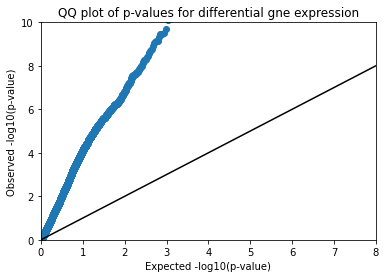

In [148]:
##QQ plot
fig, ax = plt.subplots()

ax.scatter(log_uniform_points, log_pvalues)
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
ax.set_title("QQ plot of p-values for differential gne expression")
plt.show()
# Comment: I'm surprised by this QQ plot. Looks like everything is differentially regulated! 

In [165]:
# Report list of genes with false discovery rate 
corrected_fdr_values=fdrcorrection(p_values,alpha=0.1)
i=0
relevant_genes=[]
while i<len(corrected_fdr_values[0]): 
    #Only choose values less than .1
    if corrected_fdr_values[1][i]<0.1:
        relevant_genes.append(gene_names[i])
    i+=1
print("List of genes that are significant after fdr correction:")
print(relevant_genes)

List of genes that are significant after fdr correction:
3934


In [169]:
#make an array for each day with sex as an extra variable. Jank I know 
sex_gene_names=[]
sexy_p_values=[]
beta=[]
for index,row in log_fpkm.iterrows():
    x=[10,10,11,11,12,12,13,13,14,14,14,14,14,14,14,14]
    y=[[row['male_10'],0],[row['female_10'],1],
      [row['male_11'],0],[row['female_11'],1],
      [row['male_12'],0],[row['female_10'],1],
      [row['male_13'],0],[row['female_13'],1],
      [row['male_14A'],0],[row['female_14A'],1],
      [row['male_14B'],0],[row['female_14B'],1],
      [row['male_14C'],0],[row['female_14A'],1],
      [row['male_14D'],0],[row['female_14D'],1]]
    y2=sm.add_constant(y)
    model=sm.OLS(x,y2)
    model_test=model.fit()
    sex_gene_names.append(index)
    sexy_p_values.append(model_test.pvalues[1])
    beta.append(model_test.params[1])


In [171]:
# Report list of genes with false discovery rate 
sex_corrected_fdr_values=fdrcorrection(sexy_p_values,alpha=0.1)
significant=[]
i=0
sex_relevant_genes=[]
#goes through list of genes and adds them to a list if they are 
while i<len(sex_corrected_fdr_values[0]): 
    if sex_corrected_fdr_values[1][i]<0.1:
        sex_relevant_genes.append(sex_gene_names[i])
        significant.append("Yes")
    else:
        significant.append("No")
    i+=1
    
print("List of genes that are significant after sex fdr correction:")
print(sex_relevant_genes)

List of genes that are significant after sex fdr correction:
['Parp', 'Tim17b', 'CG41128', 'CG12581', 'CG14641', 'abs', 'Vps24', 'CG9776', 'hkb', 'CG11739', 'CG11739', 'CG9855', 'CG9855', 'CG14647', 'lost', 'srl', 'eIF3-S10', 'CG31523', 'Fip1', 'CG9775', 'CG9775', 'rpk', 'CG9769', 'tacc', 'atms', 'Hus1-like', 'Gnf1', 'corto', 'corto', 'corto', 'corto', 'CG2604', 'CG12163', 'CG12173', 'Hph', 'Hph', 'Hph', 'CR45033', 'Prosbeta7', 'Prosbeta7', 'RpII18', 'CG14667', 'PEK', 'Snr1', 'Hdac3', 'CG45100', 'ksr', 'ksr', 'ksr', 'CG31550', 'Pcmt', 'Snm1', 'rev7', 'noi', 'kra', 'Atu', 'CG2911', 'RpL13A', 'snoRNA:Me28S-U2134a', 'CG31551', 'CG31549', 'CG31548', 'Sec23', 'MED27', 'Rab23', 'CG2100', 'CG2100', 'Sym', 'Madm', 'CG2091', 'CG2051', 'Rpn5', 'CG1218', 'CG10979', 'CG10979', 'Hpr1', 'CG2023', 'CG2023', 'Rm62', 'SmD2', 'CG18048', 'CG42724', 'CG42724', 'TfIIFalpha', 'CG9727', 'CG1307', 'CG1307', 'agt', 'zen2', 'zen2', 'zen', 'bcd', 'bcd', 'CR45593', 'CR44930', 'ftz', 'CR44931', 'CR45559', 'CG1943'

In [164]:
# list of genes that are relevant
i=0
for gene in sex_relevant_genes:
    if gene in relevant_genes:
        i+=1
print(i)
print("Percantage overlap: "+str(i/len(relevant_genes)))

3566
Percantage overlap: 0.9064565327910523


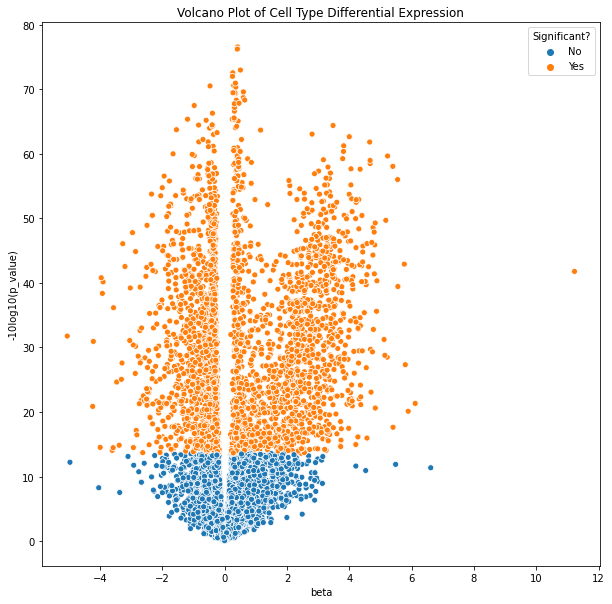

In [159]:
#volcano plot time

volcano_plot={'-10log10(p_value)':-10*np.log10(sexy_p_values),'beta': beta,'significant':significant}
vol_data=pd.DataFrame(volcano_plot)
vol_data
fig,ax=plt.subplots(figsize=(10,10))
ax.set_title("Volcano Plot of Cell Type Differential Expression")

#hue has a bug, so couldn't just get it from the Data frame 
sns.scatterplot(data=vol_data, x="beta",y="-10log10(p_value)",hue=vol_data.significant.to_list())
plt.legend(title="Significant?")
plt.show()